In [27]:
import torch
import matplotlib.pyplot as plt
from timeit import timeit
import scaleformer
from scaleformer._functions import mask_chronological

In [38]:
R = 4
N = 10
h = 4
d = 64
D = h*d
num_repeats = 10

## 1) Attention timing

In [55]:
def scaled_dot_product_attention(q, k, v, mask):
    return scaleformer._multihead_attention.MultiHeadAttention._scaled_dot_product_attention(None, q, k, v, mask)[0]

def kernelized_attention(q, k, v, mask):
    return scaleformer._scalable_attention.ScalableAttention._linear_kernelized_attention(None, q, k, v, mask is not None)[0]

In [56]:
vanilla_masked = []
vanilla_bidirectional = []
linear_masked = []
linear_bidirectional = []
sequence_length = []

for l in [2**i for i in range(4, 11)]:
    print(f"sequence of length {l}")
    Lq, Lk = l, l
    # tensors
    q = torch.rand((N, h, Lq, d))
    v = torch.rand((N, h, Lk, d))
    k = torch.rand((N, h, Lk, d))
    mask = mask_chronological(Lq, Lk, "cpu")
    # timing
    sequence_length.append(l)
    vanilla_masked.append(timeit(lambda: scaled_dot_product_attention(q, k, v, mask), number=num_repeats))
    vanilla_bidirectional.append(timeit(lambda: scaled_dot_product_attention(q, k, v, None), number=num_repeats))
    linear_masked.append(timeit(lambda: kernelized_attention(q, k, v, mask), number=num_repeats))
    linear_bidirectional.append(timeit(lambda: kernelized_attention(q, k, v, None), number=num_repeats))

sequence length 16
sequence length 32
sequence length 64
sequence length 128
sequence length 256
sequence length 512
sequence length 1024


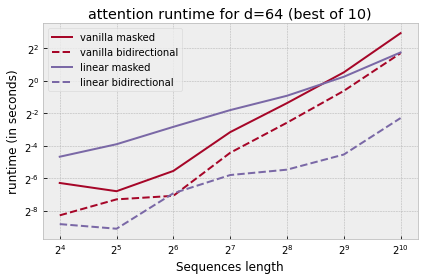

In [57]:
plt.style.use("bmh")
f, ax = plt.subplots()
ax.set_title(f"attention runtime for d={d} (best of {num_repeats})")
ax.set_xscale("log", basex=2)
ax.set_yscale("log", basey=2)
ax.set_xlabel("Sequences length")
ax.set_ylabel("runtime (in seconds)")
ax.plot(sequence_length, vanilla_masked, color="C1", linestyle="-", label="vanilla masked")
ax.plot(sequence_length, vanilla_bidirectional, linestyle="--", color="C1", label="vanilla bidirectional")
ax.plot(sequence_length, linear_masked, linestyle="-", color="C2", label="linear masked")
ax.plot(sequence_length, linear_bidirectional, linestyle="--", color="C2", label="linear bidirectional")
# ax.set_aspect("equal")
f.tight_layout()
plt.legend()
plt.show()

## 2) Relative positional encoding timing

In [61]:
def vanilla_RPE(q, RPE, v, masked: bool):
    return scaleformer._scalable_attention.ScalableAttention._naive_RPE(None, q, RPE, v, masked=masked)


def linear_RPE(q, RPE, v, masked: bool):
    return scaleformer._scalable_attention.ScalableAttention._linear_RPE(None, q, RPE, v, masked=masked)

In [62]:
vanilla_masked = []
vanilla_bidirectional = []
linear_masked = []
linear_bidirectional = []
sequence_length = []

for l in [2**i for i in range(4, 11)]:
    print(f"sequence of length {l}")
    Lq, Lk = l, l
    # tensors
    q = torch.rand((N, h, Lq, d))
    RPE = torch.rand((2*R+1, d))
    v = torch.rand((N, h, Lk, d))
    # timing
    sequence_length.append(l)
    vanilla_masked.append(timeit(lambda: vanilla_RPE(q, RPE, v, masked=True), number=num_repeats))
    vanilla_bidirectional.append(timeit(lambda: vanilla_RPE(q, RPE, v, masked=False), number=num_repeats))
    linear_masked.append(timeit(lambda: linear_RPE(q, RPE, v, masked=True), number=num_repeats))
    linear_bidirectional.append(timeit(lambda: linear_RPE(q, RPE, v, masked=False), number=num_repeats))

sequence of length 16
sequence of length 32
sequence of length 64
sequence of length 128
sequence of length 256
sequence of length 512
sequence of length 1024


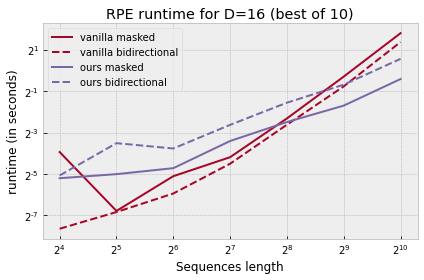

In [63]:
plt.style.use("bmh")
f, ax = plt.subplots()
ax.set_title(f"relative positional encoding runtime for d={d} (best of {num_repeats})")
ax.set_xscale("log", basex=2)
ax.set_yscale("log", basey=2)
ax.set_xlabel("Sequences length")
ax.set_ylabel("runtime (in seconds)")
ax.plot(sequence_length, vanilla_masked, color="C1", linestyle="-", label="vanilla masked")
ax.plot(sequence_length, vanilla_bidirectional, linestyle="--", color="C1", label="vanilla bidirectional")
ax.plot(sequence_length, linear_masked, linestyle="-", color="C2", label="ours masked")
ax.plot(sequence_length, linear_bidirectional, linestyle="--", color="C2", label="ours bidirectional")
f.tight_layout()
plt.legend()
plt.show()